In [1]:
import jax.numpy as jnp
import torch
import torch.nn as nn
import torch.optim as optim
features1 = torch.load('/home/sichengyu/text/NCDE/feature_tensor/2020_5CV/CV5/CV5_feature_2020_0.3_train1_whisper_30_one_norm.pt')
features2 = torch.load('/home/sichengyu/text/NCDE/feature_tensor/2020_5CV/CV5/CV5_feature_2020_0.3_val_whisper_30_one_norm.pt')

/tmp/ipykernel_2499020/44921682.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features1 = torch.load('/home/sichengyu/text/NCDE/feature_tensor/2020_5CV/CV5/CV5_feature

In [2]:
import random
import torch
import numpy as np

def set_seed(seed=42):
    random.seed(seed)              
    np.random.seed(seed)            
    torch.manual_seed(seed)           
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = False       

set_seed(400)

In [3]:
def preprocess_data(features):
    mean = features.mean((0, 1), keepdims=True)  # 形状: [1, 1, feature]
    std = features.std((0, 1), keepdims=True)    # 形状: [1, 1, feature]
    standardized_features = (features - mean) / (std + 1e-8)  # 防止除以零
    return standardized_features
features1=preprocess_data(features1)
features2=preprocess_data(features2)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ConvAutoEncoder(nn.Module):
    def __init__(self, input_channels, latent_channels):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=3,padding=1),
            nn.GELU(),
            nn.Conv1d(in_channels=128, out_channels=latent_channels, kernel_size=3,padding=1)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=latent_channels, out_channels=128, kernel_size=3,padding=1),
            nn.GELU(),
            nn.Conv1d(in_channels=128, out_channels=input_channels, kernel_size=3,padding=1)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

def train_autoencoder_with_early_stopping(
    model, train_data, val_data, epochs=50, lr=0.001, batch_size=64, patience=5, min_delta=0.001
):

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    best_epoch = 0
    epochs_no_improve = 0
    best_model_wts = model.state_dict()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            _, reconstructed = model(batch)
            loss = criterion(reconstructed, batch) 
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                _, reconstructed_val = model(val_batch)
                val_loss = criterion(reconstructed_val, val_batch)
                epoch_val_loss += val_loss.item()

        val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0  
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. Best epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
            break
            
    model.load_state_dict(best_model_wts)
    print(f"Model restored to epoch {best_epoch} with Val Loss: {best_val_loss:.6f}")

    return model, train_losses, val_losses, best_epoch



def plot_losses(train_losses, val_losses=None):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    if val_losses is not None:
        plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction Loss (MSE)")
    plt.title("Training and Validation Reconstruction Loss")
    plt.legend()
    plt.show()

def extract_features(model, data, save_path=None):
    model.eval()
    with torch.no_grad():
        latent, _ = model(data)

    latent_np = latent.numpy()

    if save_path:
        import numpy as np
        np.save(save_path, latent_np)
        print(f"Low-dimensional features saved to: {save_path}")

    return latent_np

Epoch 1/200, Train Loss: 0.923306, Val Loss: 0.836577
Epoch 2/200, Train Loss: 0.792649, Val Loss: 0.741285
Epoch 3/200, Train Loss: 0.722512, Val Loss: 0.691957
Epoch 4/200, Train Loss: 0.682671, Val Loss: 0.660539
Epoch 5/200, Train Loss: 0.654384, Val Loss: 0.636424
Epoch 6/200, Train Loss: 0.632397, Val Loss: 0.618635
Epoch 7/200, Train Loss: 0.616774, Val Loss: 0.604475
Epoch 8/200, Train Loss: 0.604186, Val Loss: 0.592953
Epoch 9/200, Train Loss: 0.594669, Val Loss: 0.584592
Epoch 10/200, Train Loss: 0.585374, Val Loss: 0.576500
Epoch 11/200, Train Loss: 0.578457, Val Loss: 0.570582
Epoch 12/200, Train Loss: 0.572516, Val Loss: 0.564389
Epoch 13/200, Train Loss: 0.567931, Val Loss: 0.560644
Epoch 14/200, Train Loss: 0.562626, Val Loss: 0.556056
Epoch 15/200, Train Loss: 0.558948, Val Loss: 0.551718
Epoch 16/200, Train Loss: 0.555026, Val Loss: 0.548654
Epoch 17/200, Train Loss: 0.552247, Val Loss: 0.545949
Epoch 18/200, Train Loss: 0.548919, Val Loss: 0.542944
Epoch 19/200, Train

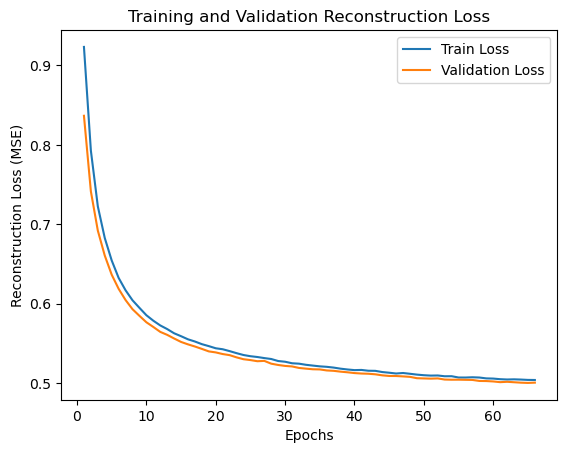

In [6]:
import os
import numpy as np

if __name__ == "__main__":
    
    train_data = features1 
    test_data = features2 
    train_data = train_data.permute(0, 2, 1)
    test_data=test_data.permute(0, 2, 1)

    folder_path = "2020/CV"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 创建文件夹
        print(f"Created folder: {folder_path}")

    autoencoder = ConvAutoEncoder(input_channels=768, latent_channels=32)

    autoencoder, train_losses, val_losses,best_epoch = train_autoencoder_with_early_stopping(
        autoencoder, train_data, test_data, epochs=200, lr=0.001, batch_size=16
    )

    plot_losses(train_losses, val_losses)
    


In [7]:
train_features = extract_features(autoencoder, train_data)
train_features = np.transpose(train_features, (0, 2, 1))
train_file_path = os.path.join(folder_path, "train_features_2020_conv1_CV5_norm_one.npy")
np.save(train_file_path, train_features)
print(f"Train features shape: {train_features.shape}")
print(f"Train features saved at: {train_file_path}")


test_features = extract_features(autoencoder, test_data)
test_features = np.transpose(test_features, (0, 2, 1))
test_file_path = os.path.join(folder_path, "val_features_2020_conv1_CV5_norm_one.npy")
np.save(test_file_path, test_features)

print(f"Test features shape: {test_features.shape}")
print(f"Test features saved at: {test_file_path}")
print(f"Training completed. Best epoch: {best_epoch}")

Train features shape: (285, 1500, 32)
Train features saved at: 2020/CV/train_features_2020_conv1_CV5_norm_one.npy
Training completed. Best epoch: 61
Test features shape: (61, 1500, 32)
Test features saved at: 2020/CV/val_features_2020_conv1_CV5_norm_one.npy
